In [6]:
#pip install dice_ml

In [7]:
import dice_ml
import pandas as pd
import numpy as np
from sklearn.datasets import make_moons
import tensorflow as tf
from tensorflow import keras
from numpy.linalg import norm
from shapely.geometry import Polygon
from sklearn.datasets import load_wine
import math
from sklearn.decomposition import PCA
from keras.utils import to_categorical
from copy import copy
from numpy.random import normal
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "


In [8]:
def generate_halfmoons(n_samples,noise,verbose=True):
    X , y = make_moons(n_samples,noise=noise)

    if verbose  : plt.scatter(X[:,0],X[:,1],c=y)

    return X , y



def plot_decision_boundary(X, y, model,sample,contrf,title="Counterfactual"):

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    Z = np.round(model.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)


    # have to sort points in order to get a polygon
    points  = np.array(contrf)[:,:2]
    new_points = points[points[:, 0].argsort()]
    a , b = zip(*new_points)

    if sample is not None:
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
        plt.scatter(sample[0], sample[1], c='pink', marker='o', s=50, label='Sample')
        for con in contrf[:-1]:
            plt.scatter(con[0], con[1], c='yellow', marker='X', s=50)
        plt.scatter(contrf[-1][0], contrf[-1][1], c='yellow', marker='X', s=50,label=title)
        plt.plot(a + (a[0],), b + (b[0],), c='blue')
        plt.fill(a, b, alpha=0.5, color='yellow',label="Diveristy with area")
    else:
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.title("Grawing Sphere "+title)
    plt.xlabel("dim 1")
    plt.ylabel("dim 2")
    plt.legend()
    plt.show()

## Data import

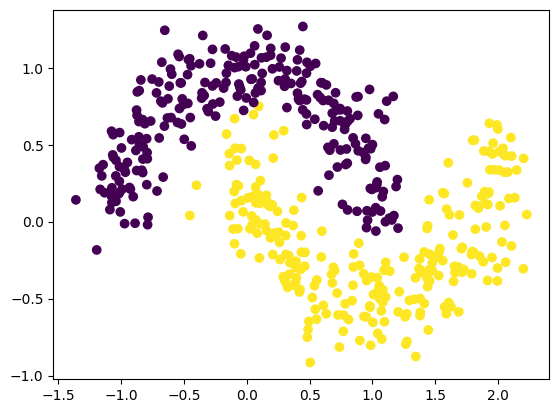

In [9]:
n_samples = 500
noise = 0.15
X , y = generate_halfmoons(n_samples,noise,verbose=True)
data_dimension = X.shape[1]

In [10]:
df = pd.DataFrame(X,columns=["x1","x2"])
df["class"] = y

# load the data as DiCE format
data = dice_ml.Data(dataframe = df,continuous_features = ["x1","x2"],outcome_name="class")

## Classifiers

- Creating a neural network with some hidden layers to learn a non lineaire boundary

In [11]:

NN_3 = keras.Sequential([
    keras.layers.Input(shape=(data_dimension,)),
    keras.layers.Dense(20, activation='tanh'),
    keras.layers.Dense(17, activation='relu'),
    keras.layers.Dense(6, activation='tanh'),
    keras.layers.Dense(1, activation='sigmoid')
])

NN_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

NN_3.fit(X, y, epochs=200, batch_size=100)

Epoch 1/200
5/5 [==============================] - 2s 6ms/step - loss: 0.6585 - accuracy: 0.6380
Epoch 2/200
5/5 [==============================] - 0s 5ms/step - loss: 0.6227 - accuracy: 0.7000
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.5909 - accuracy: 0.7500
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.5619 - accuracy: 0.7900
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.5340 - accuracy: 0.8040
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.5087 - accuracy: 0.8240
Epoch 7/200
5/5 [==============================] - 0s 6ms/step - loss: 0.4853 - accuracy: 0.8320
Epoch 8/200
5/5 [==============================] - 0s 6ms/step - loss: 0.4651 - accuracy: 0.8360
Epoch 9/200
5/5 [==============================] - 0s 4ms/step - loss: 0.4460 - accuracy: 0.8420
Epoch 10/200
5/5 [==============================] - 0s 4ms/step - loss: 0.4289 - accuracy: 0.8480
Epoch 11/200
5/5 [===========

# Generation of counterfactual

In [12]:
def generate_counterfactual_samples(trained_classifier,X,y,feature_names,sample_ind,total_CFs,proximity_weight,diversity_weight,desired_class="opposite",verbose=True):
    """
    **trained_classifier** : a classifier already trained on some data
    **sample_ind** : the index of the sample to generate counterfactual examples
    **total_CFs** : the number of counterfactual examples to generate
    **proximity_weight** : proximity weight to DiCE algorithme
    **diversity_weight** : diversity weight to DiCE algorithme
    """


    # load the classfier as format DiCE
    model = dice_ml.Model(model=trained_classifier, backend="TF1")

    # prepare data
    df = pd.DataFrame(X,columns=feature_names)
    df["class"] = y

    # load the data as DiCE format
    data = dice_ml.Data(dataframe = df,continuous_features =feature_names,outcome_name="class")

    # an explainer is initialized
    explainer = dice_ml.Dice(data, model)

    # the sample we want to generate diverse counterfactual exemples
    query_inst = pd.DataFrame(df.iloc[sample_ind:sample_ind+1,:X[0].shape[0]],columns=feature_names)


    # generation

    counterfactuals = explainer.generate_counterfactuals(
        query_inst,
        total_CFs,
        desired_class=desired_class,
        proximity_weight=proximity_weight,
        diversity_weight=diversity_weight,
        features_to_vary="all",
        permitted_range=None,
        posthoc_sparsity_param=0.3)

    # just to visualize counterfactual examples
    #print(counterfactuals.visualize_as_dataframe())

    # counterfactual predictions
    counterfactual_predictions = counterfactuals.cf_examples_list[0].final_cfs_df.iloc[:,2]


    # get the enemies
    enemies = counterfactuals.cf_examples_list[0].final_cfs_df

    # plot
    if verbose: plot_decision_boundary(X, y,trained_classifier,X[sample_ind],np.array(enemies))


    return enemies , counterfactual_predictions

# Variations

## vary the sample request

100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


7320/7320 [==============================] - 23s 3ms/step


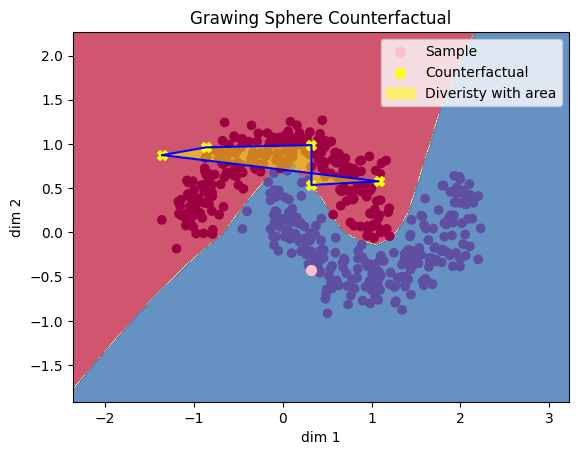

In [13]:
trained_classifier = NN_3
feature_names = ['x1','x2']
sample_ind = 0
total_CFs = 5
proximity_weight = 0.8
diversity_weight = 1.0

enemies , preds = generate_counterfactual_samples(
        trained_classifier,
        X,y,feature_names,
        sample_ind,
        total_CFs,
        proximity_weight,
        diversity_weight)

100%|██████████| 1/1 [03:05<00:00, 185.63s/it]

  66/7320 [..............................] - ETA: 11s

7320/7320 [==============================] - 12s 2ms/step


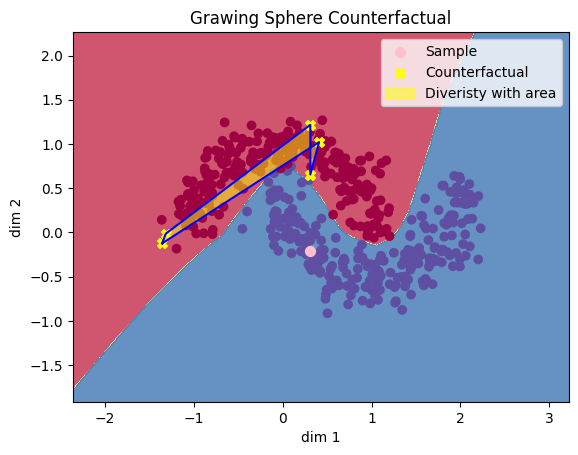

In [14]:
trained_classifier = NN_3
sample_ind = 16
total_CFs = 5
proximity_weight = 0.7
diversity_weight = 1.0

enemies , preds = generate_counterfactual_samples(
        trained_classifier,
        X,y,feature_names,
        sample_ind,
        total_CFs,
        proximity_weight,
        diversity_weight)

## Vary parameters

We define three situations
- 1 --> we focus on the diversity
- 2 --> we focus on the proximity
- 3 --> a compromise between the diversity and the proximity.

and then we'll see the results of the algorithme on this situations.

Focus diveristy


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

  81/7320 [..............................] - ETA: 9s

7320/7320 [==============================] - 11s 1ms/step


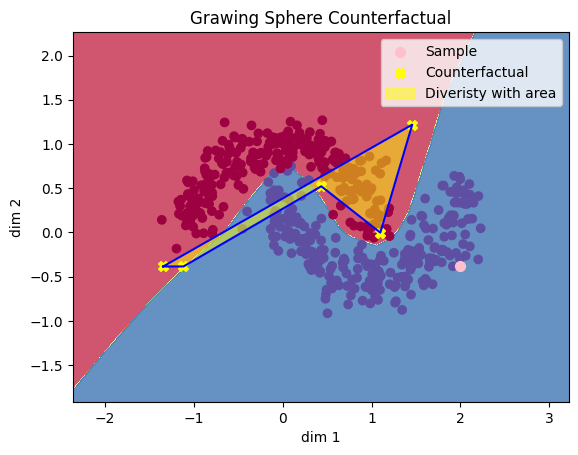

Focus proximity


100%|██████████| 1/1 [01:03<00:00, 63.20s/it]

  69/7320 [..............................] - ETA: 10s

7320/7320 [==============================] - 11s 1ms/step


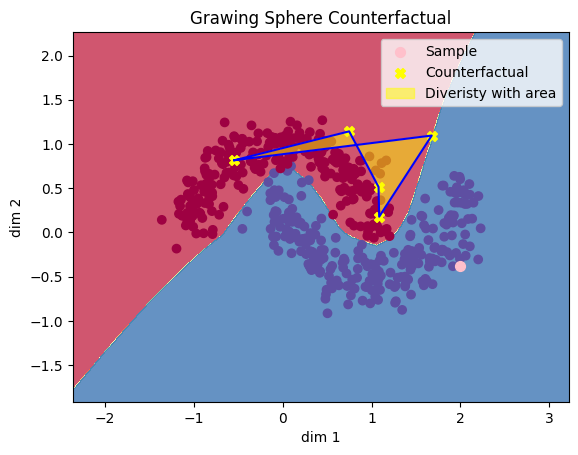

Compromise diversity/proximity


100%|██████████| 1/1 [01:02<00:00, 62.95s/it]

  27/7320 [..............................] - ETA: 14s 

7320/7320 [==============================] - 11s 1ms/step


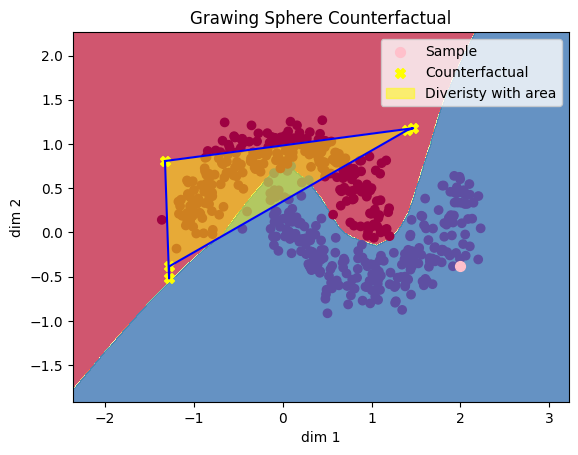

In [15]:
situations = [[1.0 , 9.0] , [9.0 , 1.0] , [1.5 , 1.5]]
messages = ["Focus diveristy" , "Focus proximity" , "Compromise diversity/proximity"]

trained_classifier = NN_3
sample_ind = 96
total_CFs = 5


for i,situ in enumerate(situations):
  print(messages[i])
  enemies , _ = generate_counterfactual_samples(
          trained_classifier,
          X,y,feature_names,
          sample_ind,
          total_CFs,
          situ[0],
          situ[1])


- We note that by using parameters that allow a total focus on diversity, we obtain diverse counterfactual examples covering a rather large area for the polygon.
- So much so that by focusing on proximity, we obtain examples close to the original example without having a huge diversity of counterfactuals.
- The most interesting case is the one that combines a compromise between diversity and proximity: we obtain a polygon with a practically large surface area (high diversity) while remaining in an area close to the original example.

## Define the relevance metric

- We defend a metric of increasing relevance (as long as it is great as long as the generation of counterfactual examples is more relevant).
- We defend a weighted average of 4 entities ( validity , diveristy , parsimony , proximity ) For the first 3 we want their values to be large while for the last one we want it to be smaller at most ( closer to the original example ) that's why in the metric we take the weight associated with proximity multiplied by 1/proximity .
- Before applying the weighted average, the 4 criteria are normalized on the basis of a range of values provided as parameters.
- A combination of parameters giving a score of 2 is more relevant than one giving a score of 1.5.


In [16]:

def proximity(vector1,vector2):

  return norm(vector1 - vector2)


def relevance(sample,enemies,counterfactual_predictions,prediction_target,plage_norm,weights,verbose=False):
    """
    **sample** : sample for which we want to generate counterfactuals
    **enemies** : counterfactuals
    **counterfactual_predictions** : the model's predictions on counterfactuals
    **predicition_target** : the model's prediction on the sample
    **plage_norm** : the range in which normalization is performed
    **weights** : weights of the four criteria

    """

    plage_norm_min,plage_norm_max = plage_norm

    # validity between 0.0 and 1.0
    # the others criteria are higher that 1 so we'll translate this mean to [2,4]
    validity = np.where(prediction_target != counterfactual_predictions,1,0).mean()
    validity_norm = (validity - 0) / (1 - 0) * (plage_norm_max - plage_norm_min) + plage_norm_min

    # proximity
    proxi = proximity(sample,enemies)
    proxi_2 = int(proxi + 1)
    proxi_1 = int(proxi - 1)
    proxi_norm = (proxi -proxi_1 ) / (proxi_2 - proxi_1) * (plage_norm_max - plage_norm_min) + plage_norm_min
    # because we want to minimize the proximity between the sample and his counterfactuals , we'll use (1/proxi_norm)
    # we will encourage in our metric that the proximity is as low as possible
    proxi_norm = 1 / proxi_norm


    # diveristy : surface area of the geometric shape formed by the points
    new_ene = enemies.iloc[enemies.iloc[:, 0].argsort()]
    # case multiclass
    if new_ene.shape[1] != 2:
      pca = PCA(n_components=2)
      new_ene = pca.fit_transform(new_ene)
    polygon = Polygon(new_ene)
    diveristy = polygon.area
    diveristy_2 = int(diveristy + 1)
    diveristy_1 = int(diveristy - 1)
    diveristy_norm = (diveristy - diveristy_1) / (diveristy_2 - diveristy_1) * (plage_norm_max - plage_norm_min) + plage_norm_min

    # sparsness
    sparsness = len(np.where(sample == enemies)[0]) / (enemies.shape[0]*enemies.shape[1])
    sparsness_norm = (sparsness - 0) / (1 - 0) * (plage_norm_max - plage_norm_min) + plage_norm_min

    # display
    if verbose:
      print(f"Validity : {validity} , Proximity : {proxi} , Diversity : {diveristy} , Sparsness : {sparsness}")


    # relevance : weighted mean
    return (weights * np.array([validity_norm,proxi_norm,diveristy_norm, sparsness_norm])).mean() , [validity,proxi,diveristy,sparsness]

100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

  72/7320 [..............................] - ETA: 10s

7320/7320 [==============================] - 11s 1ms/step


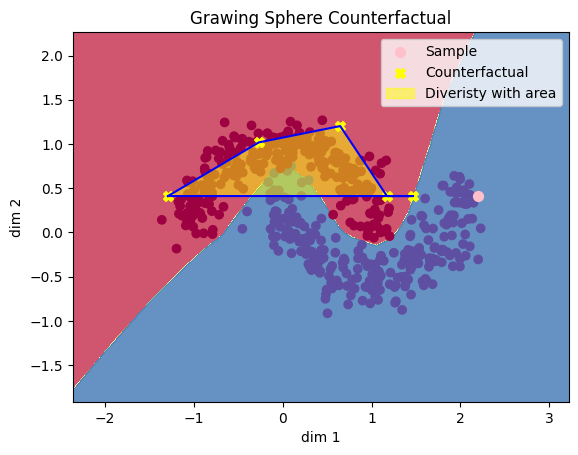

16/16 [==============================] - 0s 1ms/step
Validity : 1.0 , Proximity : 4.828644902586536 , Diversity : 1.1583504074944855 , Sparsness : 0.3
Relevance of the counterfactuals generation on this configuration is 7.639721535436727


In [17]:
trained_classifier = NN_3
sample_ind = 14
total_CFs = 5
proximity_weight = 0.7
diversity_weight = 1.0

enemies , counterfactual_predictions = generate_counterfactual_samples(
        trained_classifier,
        X,y,feature_names,
        sample_ind,
        total_CFs,
        proximity_weight,
        diversity_weight,
        verbose=True)


sample = X[sample_ind]
counters = enemies.iloc[:,:data_dimension]
plage_norm = [2,4]
prediction_target = int(np.round(NN_3.predict(X))[sample_ind][0])
# validity , proximity , diveristy , sparsness
weights= np.array([2,6,5,2])
rele , _ = relevance(sample,counters,counterfactual_predictions,prediction_target,plage_norm,weights,True)
print(f"Relevance of the counterfactuals generation on this configuration is {rele}")

In [18]:
situations = [[1.0 , 9.0] , [9.0 , 1.0] , [1.5 , 1.5]]
messages = ["Focus diveristy" , "Focus proximity" , "Compromise diversity/proximity"]

trained_classifier = NN_3
# sample_ind = 14
samples = [14,96,24,10,6,23]
total_CFs = 5

relevances = []
validities = []
proximities = []
diversities = []
sparsnesses = []
tmp_v = []
tmp_r = []
tmp_p = []
tmp_s = []
tmp_d = []

for i,situ in enumerate(situations):
  for sample_ind in samples:
    print(messages[i])
    enemies , _ = generate_counterfactual_samples(
            trained_classifier,
            X,y,feature_names,
            sample_ind,
            total_CFs,
            situ[0],
            situ[1],
            verbose=False)

    sample = X[sample_ind]
    counters = enemies.iloc[:,:2]
    plage_norm = [2,4]
    prediction_target = int(np.round(NN_3.predict(X))[sample_ind][0])
    # validity , proximity , diveristy , sparsness
    weights= np.array([2,6,5,2])
    rele , criteria_values = relevance(sample,counters,counterfactual_predictions,prediction_target,plage_norm,weights,True)
    print(f"Relevance of the counterfactuals generation on this configuration is {rele}")
    tmp_r.append(rele)
    tmp_v.append(criteria_values[0])
    tmp_p.append(criteria_values[1])
    tmp_d.append(criteria_values[2])
    tmp_s.append(criteria_values[3])
  relevances.append(np.mean(tmp_r))
  validities.append(np.mean(tmp_v))
  proximities.append(np.mean(tmp_p))
  diversities.append(np.mean(tmp_d))
  sparsnesses.append(np.mean(tmp_s))


Focus diveristy


100%|██████████| 1/1 [02:04<00:00, 124.26s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 1.0 , Proximity : 6.862953725229651 , Diversity : 0.2571468781868447 , Sparsness : 0.1
Relevance of the counterfactuals generation on this configuration is 6.631171096236937
Focus diveristy


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 1.0 , Proximity : 5.62529479343209 , Diversity : 0.21117962771511314 , Sparsness : 0.1
Relevance of the counterfactuals generation on this configuration is 6.541708524854689
Focus diveristy


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 0.0 , Proximity : 2.9716488635543366 , Diversity : 0.49383514038328735 , Sparsness : 0.3
Relevance of the counterfactuals generation on this configuration is 6.412264743234544
Focus diveristy


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 0.0 , Proximity : 3.7786364702426405 , Diversity : 0.7560534859888073 , Sparsness : 0.2
Relevance of the counterfactuals generation on this configuration is 6.987102307164662
Focus diveristy


100%|██████████| 1/1 [01:02<00:00, 62.63s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 1.0 , Proximity : 5.319530125113603 , Diversity : 0.4461774242104705 , Sparsness : 0.1
Relevance of the counterfactuals generation on this configuration is 7.167314742128623
Focus diveristy


100%|██████████| 1/1 [01:04<00:00, 64.98s/it]

16/16 [==============================] - 0s 3ms/step


Validity : 0.0 , Proximity : 3.7069104514689464 , Diversity : 0.37270554229314545 , Sparsness : 0.1
Relevance of the counterfactuals generation on this configuration is 5.936413501209351
Focus proximity


100%|██████████| 1/1 [01:04<00:00, 64.85s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 1.0 , Proximity : 5.514968995991215 , Diversity : 0.03525187530544932 , Sparsness : 0.4
Relevance of the counterfactuals generation on this configuration is 6.414875984379103
Focus proximity


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 1.0 , Proximity : 6.017424345627493 , Diversity : 1.276424905052056 , Sparsness : 0.1
Relevance of the counterfactuals generation on this configuration is 7.692643843411275
Focus proximity


100%|██████████| 1/1 [02:04<00:00, 124.94s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 0.0 , Proximity : 3.355363076617962 , Diversity : 0.6472541642083038 , Sparsness : 0.3
Relevance of the counterfactuals generation on this configuration is 6.865180921169915
Focus proximity


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 0.0 , Proximity : 2.0746253878958143 , Diversity : 0.453799649252493 , Sparsness : 0.4
Relevance of the counterfactuals generation on this configuration is 6.522363435286202
Focus proximity


100%|██████████| 1/1 [02:05<00:00, 125.81s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 1.0 , Proximity : 6.206942466209022 , Diversity : 0.31891317119403106 , Sparsness : 0.1
Relevance of the counterfactuals generation on this configuration is 6.865018166707079
Focus proximity


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 0.0 , Proximity : 3.596299113095901 , Diversity : 1.0392977356512272 , Sparsness : 0.4
Relevance of the counterfactuals generation on this configuration is 6.61621762042288
Compromise diversity/proximity


100%|██████████| 1/1 [01:03<00:00, 63.31s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 1.0 , Proximity : 5.4034585021241 , Diversity : 0.8700063933824709 , Sparsness : 0.2
Relevance of the counterfactuals generation on this configuration is 8.315744142493182
Compromise diversity/proximity


100%|██████████| 1/1 [01:03<00:00, 63.45s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 1.0 , Proximity : 6.5273578733731155 , Diversity : 0.43395532826104394 , Sparsness : 0.1
Relevance of the counterfactuals generation on this configuration is 7.110135787410382
Compromise diversity/proximity


100%|██████████| 1/1 [01:03<00:00, 63.27s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 0.0 , Proximity : 3.2225790203682663 , Diversity : 0.05923630515738826 , Sparsness : 0.3
Relevance of the counterfactuals generation on this configuration is 5.4135564630421005
Compromise diversity/proximity


100%|██████████| 1/1 [01:03<00:00, 63.54s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 0.0 , Proximity : 2.482204749971479 , Diversity : 0.4146966921589334 , Sparsness : 0.2
Relevance of the counterfactuals generation on this configuration is 6.167503304659239
Compromise diversity/proximity


100%|██████████| 1/1 [01:02<00:00, 62.75s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 1.0 , Proximity : 5.194327546380226 , Diversity : 0.1778272148355573 , Sparsness : 0.2
Relevance of the counterfactuals generation on this configuration is 6.614150438461533
Compromise diversity/proximity


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

16/16 [==============================] - 0s 2ms/step
Validity : 0.0 , Proximity : 3.538021122159205 , Diversity : 0.21016546442910666 , Sparsness : 0.4
Relevance of the counterfactuals generation on this configuration is 5.849379473658015


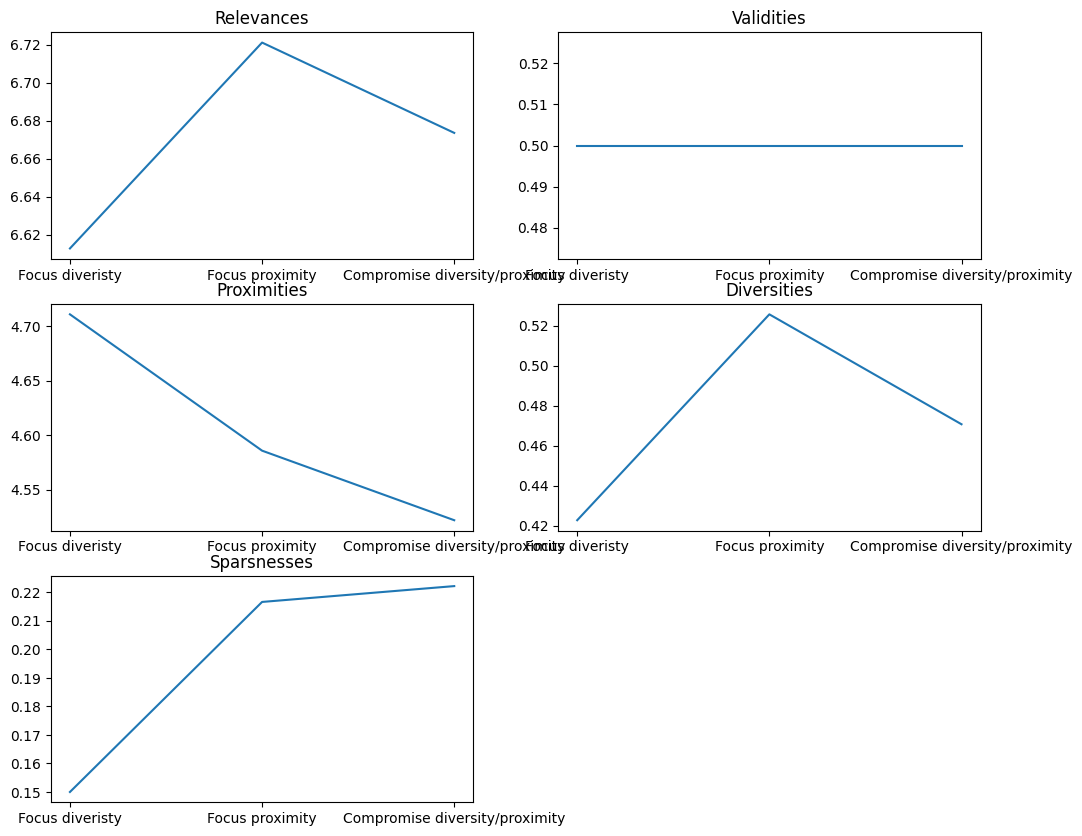

In [19]:
plt.figure(figsize=(12,10))
plt.subplot(321)
plt.title("Relevances")
plt.plot(messages , relevances)

plt.subplot(322)
plt.title("Validities")
plt.plot(messages , validities)

plt.subplot(323)
plt.title("Proximities")
plt.plot(messages , proximities)

plt.subplot(324)
plt.title("Diversities")
plt.plot(messages , diversities)

plt.subplot(325)
plt.title("Sparsnesses")
plt.plot(messages , sparsnesses)

We note that :
- The diversity/proximity compromise strategy is the most relevant.
- On average, there may be situations where the proximity/diversity combination produces more diversity than the pure strategy, because depending on the example chosen, it may be in an area where its counterfactuals will be more diverse than if they were far from the original example.
- Sparsness match well with the diverist/proximity strategy, because by being diverse and close, we're more likely to find the same values as the original example.
- Validity is more or less stable whatever the strategy.

## Wine Data

In [20]:
# Load the Wine dataset
wine_data = load_wine()

# Access the features and target variables
X = wine_data.data  # Features
y = wine_data.target  # Target variable
# one hot vector
y_nn = to_categorical(y, num_classes=3)


feature_names = list(np.array(wine_data.feature_names))
target_names = wine_data.target_names
dataset_description = wine_data.DESCR
data_dimension = X.shape[1]

In [21]:
NN_3_bis = keras.Sequential([
    keras.layers.Input(shape=(data_dimension,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

NN_3_bis.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

NN_3_bis.fit(X,y_nn, epochs=100, batch_size=64)

Epoch 1/100
3/3 [==============================] - 1s 7ms/step - loss: 20.1079 - accuracy: 0.2528
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 13.9819 - accuracy: 0.2978
Epoch 3/100
3/3 [==============================] - 0s 5ms/step - loss: 8.4733 - accuracy: 0.1629
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 5.8790 - accuracy: 0.2697
Epoch 5/100
3/3 [==============================] - 0s 5ms/step - loss: 4.1005 - accuracy: 0.3371
Epoch 6/100
3/3 [==============================] - 0s 5ms/step - loss: 2.8418 - accuracy: 0.2697
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 1.6992 - accuracy: 0.3483
Epoch 8/100
3/3 [==============================] - 0s 5ms/step - loss: 1.4868 - accuracy: 0.3708
Epoch 9/100
3/3 [==============================] - 0s 5ms/step - loss: 1.3875 - accuracy: 0.3933
Epoch 10/100
3/3 [==============================] - 0s 6ms/step - loss: 1.2335 - accuracy: 0.4157
Epoch 11/100
3/3 [=========

### Desired class is the class 2

In [22]:
trained_classifier = NN_3_bis
sample_ind = 14
total_CFs = 10
proximity_weight = 0.8
diversity_weight = 1.0
desired_class = 2

enemies , counterfactual_predictions = generate_counterfactual_samples(
        trained_classifier,
        X,y,feature_names,
        sample_ind,
        total_CFs,
        proximity_weight,
        diversity_weight,
        desired_class,
        verbose=False)

100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


In [23]:
counterssample = X[sample_ind]
counters = enemies.iloc[:,:data_dimension]
plage_norm = [2,4]
prediction_target = int(np.round(NN_3_bis.predict(X))[sample_ind][0])
# validity , proximity , diveristy , sparsness
weights= np.array([2,6,5,2])
rele , _ = relevance(counterssample,counters,counterfactual_predictions,prediction_target,plage_norm,weights,True)
print(f"Relevance of the counterfactuals generation on this configuration is {rele}")

6/6 [==============================] - 0s 2ms/step
Validity : 1.0 , Proximity : 2740.5501302658195 , Diversity : 2.780459642951712 , Sparsness : 0.6461538461538462
Relevance of the counterfactuals generation on this configuration is 8.794248106920703


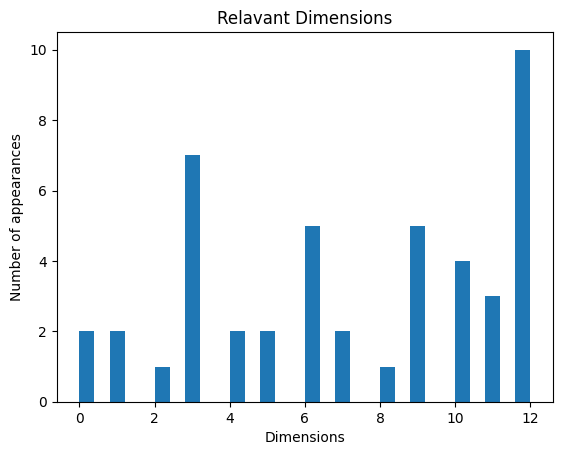

In [24]:
relevant_dims = []
all_dims = set(np.arange(13))
for ene in range(len(enemies)):
  not_relevant_dims = set(np.where(enemies.iloc[ene,:13] == counterssample)[0])
  relevant_dims.extend(all_dims - not_relevant_dims)


plt.hist(relevant_dims,bins=30)
plt.title("Relavant Dimensions")
plt.xlabel("Dimensions")
plt.ylabel("Number of appearances")
plt.show()


- We can see that if the user want a change from class 0 to class 2 for the sample with the id 14 : he has to focus the change on two main features which is **alcalinity_of_ash** and **proline**

### Desired class is the class 1

In [25]:
trained_classifier = NN_3_bis
sample_ind = 14
total_CFs = 10
proximity_weight = 0.8
diversity_weight = 1.0
desired_class = 1

enemies , counterfactual_predictions = generate_counterfactual_samples(
        trained_classifier,
        X,y,feature_names,
        sample_ind,
        total_CFs,
        proximity_weight,
        diversity_weight,
        desired_class,
        verbose=False)


counterssample = X[sample_ind]
counters = enemies.iloc[:,:data_dimension]
plage_norm = [2,4]
prediction_target = int(np.round(NN_3_bis.predict(X))[sample_ind][0])
# validity , proximity , diveristy , sparsness
weights= np.array([2,6,5,2])
rele , _ = relevance(counterssample,counters,counterfactual_predictions,prediction_target,plage_norm,weights,True)
print(f"Relevance of the counterfactuals generation on this configuration is {rele}")

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

6/6 [==============================] - 0s 3ms/step
Validity : 1.0 , Proximity : 3359.538729528207 , Diversity : 16.429692429244987 , Sparsness : 0.8692307692307693
Relevance of the counterfactuals generation on this configuration is 8.580227246119838


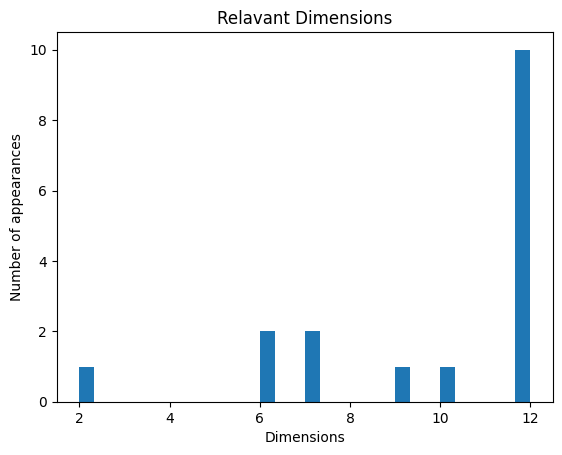

In [26]:
relevant_dims = []
all_dims = set(np.arange(13))
for ene in range(len(enemies)):
  not_relevant_dims = set(np.where(enemies.iloc[ene,:13] == counterssample)[0])
  relevant_dims.extend(all_dims - not_relevant_dims)


plt.hist(relevant_dims,bins=30)
plt.title("Relavant Dimensions")
plt.xlabel("Dimensions")
plt.ylabel("Number of appearances")
plt.show()


- We can see that if the user want a change from class 0 to class 2 for the sample with the id 14 : he only has to focus the change **proline** feature.

# Growing Spheres extension

We'll propose a GS variant that allows the user to specify non-modifiable attributes and/or permitted variation ranges.

In [27]:
class Exception_GS(Exception):
    def __init__(self, message="Try to modify a feature in a wrong range"):
        self.message = message
        super().__init__(self.message)

def uniform_in_sphere(x,n_samples,a_0,a_1):
    d = x.shape[0]
    # sample from gaussian distribution
    samples = normal(0,1,(n_samples,d))

    # normalization
    samples_norm = samples / norm(samples,axis=1).reshape(-1,1)
    # sample from uniform distribution
    u = np.random.uniform(a_0**d,a_1**d,1) ** (1/d)

    return x + samples_norm * u


def algorithme_gs_generation(model,sample,eta,n_samples):

    generated_samples_sph = uniform_in_sphere(sample,n_samples,0,eta)

    prediction_samples_sph = model.predict(generated_samples_sph)

    while np.where(prediction_samples_sph != model.predict(sample.reshape(1,-1)),1,0).sum() != 0:

        eta = eta / 2

        generated_samples_sph = uniform_in_sphere(sample,n_samples,0,eta)

        prediction_samples_sph = model.predict(generated_samples_sph)

    a_0 = eta
    a_1 = 2*eta

    while np.where(prediction_samples_sph != model.predict(sample.reshape(1,-1)),1,0).sum() == 0:

        generated_samples_sph = uniform_in_sphere(sample,n_samples,a_0,a_1)

        prediction_samples_sph = model.predict(generated_samples_sph)

        a_0 = a_1
        a_1 = a_1 + eta

    prediction_samples_sph = model.predict(generated_samples_sph)
    samples_diff_class = generated_samples_sph[np.where(prediction_samples_sph != model.predict(sample.reshape(1,-1)))]

    enemy_ind = np.argmin(norm(np.array(samples_diff_class) - np.array(sample),axis=1))

    return samples_diff_class[enemy_ind]

def algorithme_gs_feature_selection(model,sample,enemy,non_modifiable_att='no',variation_range='no'):

    """
      **non_modifiable_att** : list of non modifiable attributes
      **variation_range** : a dictionnary {key:feature_index , value:range}
    """

    enemy_prime = copy(enemy)
    relevant_dimensions = []

    while model.predict(sample.reshape(1,-1)) != model.predict(enemy_prime.reshape(1,-1)):

        enemy_star = copy(enemy_prime)

        # extraire uniquement les dimensions differentes
        indices_diffe_dim = np.where(enemy_prime != sample)[0]

        indi = indices_diffe_dim[np.argmin(enemy_prime[indices_diffe_dim] - sample[indices_diffe_dim])]

        # check if the feature is in the non_modifiable list of features
        if indi not in non_modifiable_att:

          if variation_range == 'no':
            relevant_dimensions.append(indi)
            enemy_prime[indi] = sample[indi]
          else:
            # check if the feature can be modify in the correct range
            if (sample[indi]  >= variation_range[indi][0]) and (sample[indi]  <= variation_range[indi][1]):

              relevant_dimensions.append(indi)
              enemy_prime[indi] = sample[indi]

            else:
              # we have to regenerate an enemy (call the algorithme_gs_generation)
              # we'll raise an exception which we'll catch in the growing_sphere function to recall the algorithme_gs_generation
              raise Exception_GS(f"Try to modify a feature in a wrong range , {indi}")

        else:
          # in the case of the feature is in non_modifiable list
          # we have to regenerate an enemy (call the algorithme_gs_generation)
          # we'll raise an exception which we'll catch in the growing_sphere function to recall the algorithme_gs_generation
          raise Exception_GS(f"Try to modify a non-modifiable feature , {indi}")


    return enemy_star , relevant_dimensions



def growing_sphere(rd_model,sample,eta=5,n_samples=10,non_modifiable_att='no',variation_range='no'):

  not_finish = True

  enemy = algorithme_gs_generation(rd_model,sample,eta,n_samples)

  while not_finish:

    try :
      return algorithme_gs_feature_selection(rd_model,sample,enemy,non_modifiable_att,variation_range)
    except Exception as e:
      enemy = algorithme_gs_generation(rd_model,sample,eta,n_samples)


In [28]:
rd_model = RandomForestClassifier(max_depth=5)
rd_model.fit(X,y)

RandomForestClassifier(max_depth=5)

In [30]:
sample = X[14]
non_modifiable_att = [4,6]
# want to limit the range of feature 1 and 5
range_feat_1 = (X[:,1].min()+1, X[:,1].max()-1)
range_feat_5 = (X[:,5].min()+1, X[:,5].max()-1)

variation_range = {1 : range_feat_1 , 5:range_feat_5}
n_samples = 10
eta = 3

enemy_star , rele_dims = growing_sphere(rd_model,sample,eta,n_samples,non_modifiable_att,variation_range)
print(f" Relevant features are : {rele_dims}")

 Relevant features are : [1]
